# OSMF 2021 Contributor Survey Analysis

For the time period of the survey (January - February 2021), where have contributors been editing OSM, in relation to where they may live (by Country).

### How do we determine which Country a mapper might be from?
There has been a decent amount of research on this question, and it's a moving target. One reasonable thought (if we ignore humanitarian or paid-editing teams), is that the Country in which a mapper makes the majority of their changesets is perhaps their home. If not their _actual home_, it is still clearly a location they posess knowledge of and continually map. Some of Pascal Neis's tools use this approach, so I will re-create it here roughly. 

Quick & Dirty: Group all of a users changesets from the last five years together based on the rounded value of the min lon/lat from the changeset metadata. If the corner of a changeset bounding box is (11.272132, 23.838870), it becomes (11,24). Make a list of these rounded coordinates and take the MODE (most commonly occuring). Now see which Country that point falls within.

<hr>

_Note, as of January 26, the most recent data is 1/18/2021, so this is a small sampling of 2 days of editing. This approach should, however, continue to work as we get more changesets._

Thanks!

[Jennings Anderson](https://jenningsanderson.com)

In [1]:
import pandas as pd; import geopandas as gpd; import seaborn as sns
from shapely.geometry import Point;
import fiona, sys;
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

,scalerank,featurecla,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,filename,geometry
0,1,Admin-0 country,6,Belize,BLZ,0,2,Sovereign country,Belize,BLZ,...,Americas,Central America,Latin America & Caribbean,6,6,6,-99,1,BLZ.geojson,"POLYGON ((-89.14308 17.80832, -89.15091 17.955..."
1,1,Admin-0 country,4,The Bahamas,BHS,0,2,Sovereign country,The Bahamas,BHS,...,Americas,Caribbean,Latin America & Caribbean,7,7,4,-99,1,BHS.geojson,"MULTIPOLYGON (((-77.53466 23.75975, -77.78000 ..."
2,1,Admin-0 country,5,Costa Rica,CRI,0,2,Sovereign country,Costa Rica,CRI,...,Americas,Central America,Latin America & Caribbean,10,10,4,-99,1,CRI.geojson,"POLYGON ((-82.96578 8.22503, -83.50844 8.44693..."


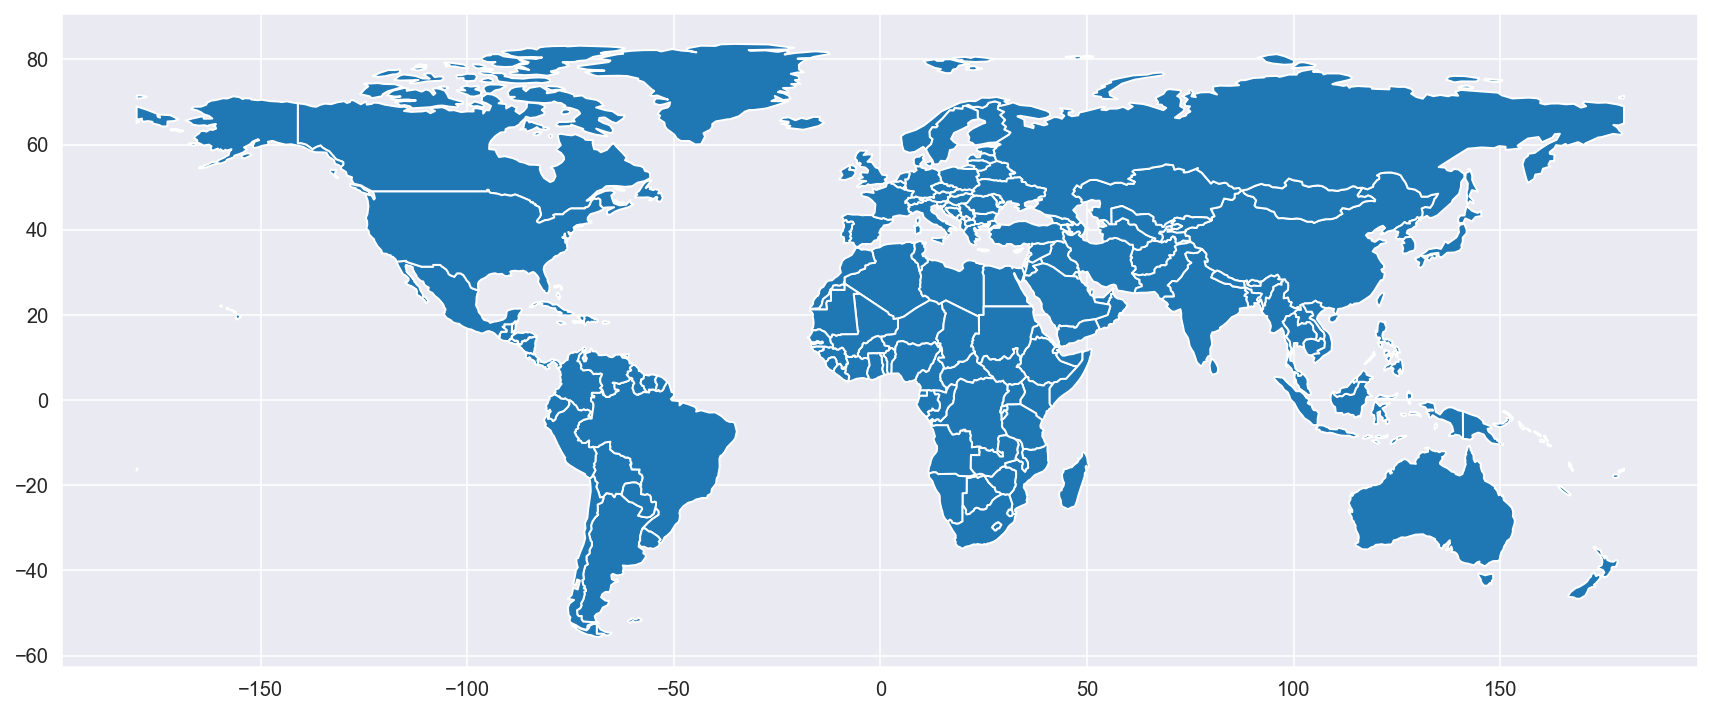

In [26]:
#First, read in a file that has Country Boundaries
countries = gpd.read_file('./data/world.geojson') #175 Countries, not perfect.
countries.plot(figsize=(16,6))
countries.head(3)

# Query:

Extract our data from the OSM Changesets data on AWS:

```sql
-- First, where does a user edit most in the last 5 years?

WITH most_frequent_editing_location AS (
  WITH rounded_coords as (
    SELECT 
      uid, 
      ARRAY[round(min_lon), round(min_lat)] AS _coords
    FROM
      changesets
    WHERE ("created_at" >= ((SELECT "max"("created_at")
                             FROM changesets) - INTERVAL  '5' YEAR))
  )
  SELECT uid, _coords AS frequent_editing_location
  FROM (SELECT uid, _coords, COUNT(*) AS cnt,
        ROW_NUMBER() OVER (PARTITION BY uid ORDER BY COUNT(*) DESC) AS seqnum
    FROM rounded_coords
    GROUP BY uid, _coords
  ) t
  WHERE seqnum = 1
), 
-- Second, who are the current active contributors?
active_contributor as (
  SELECT
    uid,
    COUNT(id) as changesets_in_last365,
    COUNT(DISTINCT(date_trunc('day', created_at))) AS editing_days_in_last365,
    SUM(num_changes) AS total_edits_in_last365,
    MAX(created_at) AS most_recent_changeset
  FROM
    changesets
  WHERE (created_at >= ((SELECT MAX(created_at) FROM changesets) - INTERVAL  '365' DAY))
  GROUP BY uid
)
-- Now join it all together
SELECT 
  id, changesets.uid, "user", min_lon, min_lat, editing_days_in_last365, frequent_editing_location
FROM changesets
LEFT JOIN active_contributors ON changesets.uid = active_contributors.uid
LEFT JOIN most_frequent_editing_location ON most_frequent_editing_location.uid = changesets.uid
WHERE created_at >= date '2021-1-16' AND created_at <= date '2021-2-14' 
```

In [4]:
#Now read in the changesets file, output from this query: 
changesets = pd.read_csv('./data/OSM_changesets.csv')
changesets['geometry'] = changesets.apply(lambda row: Point(row.min_lon, row.min_lat), axis=1)
changesets = gpd.GeoDataFrame(changesets)
changesets['country'] = None

In [9]:
# We want to find a "home country" for each user
homes = pd.DataFrame(changesets[['uid','frequent_editing_location']].drop_duplicates('uid', keep='first'))
homes.frequent_editing_location = homes.frequent_editing_location.apply(lambda c: 
                                                                        ( json.loads(c)[0], json.loads(c)[1]))
# There are aboutu 30 mappers that error out here, not sure why.
homes['geometry'] = homes.frequent_editing_location.apply(lambda t: Point(t) if t[0]!=None else None)
homes = gpd.GeoDataFrame(homes[~pd.isna(homes.geometry)]).set_crs(epsg=4326)
print("Found {:,} mappers".format(len(homes)))
homes.head(2)

Found 8,114 mappers


,uid,frequent_editing_location,geometry
0,10368595,"(44, 33)",POINT (44.00000 33.00000)
1,10041075,"(8, 50)",POINT (8.00000 50.00000)


In [10]:
#Iterate through all of the Countries and label changesets with a Country name
count=0
user_homes = []

for idx, country in countries.iterrows(): 
    # Works best with a buffer for those who edit on the coast / inlets
    this_geom_buffered = country.geometry.buffer(0.1) 
    users_from_here = homes[homes.geometry.within(this_geom_buffered)]
    edits_in_here   = changesets[changesets.geometry.within(this_geom_buffered)]

    if len(users_from_here):
        for uid in users_from_here.uid:
            user_homes.append({
                'uid':uid,
                'home_country':country.admin,
                'home_country_geom': country.geometry
            })
    
    if len(edits_in_here):
        changesets.loc[edits_in_here.index,'country'] = country.admin
        
    count+=1
    if count%5==0:
        sys.stderr.write("\r{:,} countries processed    ".format(count))

175 countries processed    

In [15]:
print("Overall, identified potential home countries for {:,} mappers".format(len(user_homes)))

Overall, identified potential home countries for 7,996 mappers


In [16]:
df = changesets.merge(pd.DataFrame(user_homes), on='uid')
df['is_local'] = df.home_country == df.country
df.head(2)

,id,uid,user,min_lon,min_lat,editing_days_in_last365,frequent_editing_location,geometry,country,home_country,home_country_geom,is_local
0,97587018,10368595,Msalmanq,44.013961,36.194207,263,"[44, 33]",POINT (44.01396 36.19421),Iraq,Iraq,"POLYGON ((45.4206181170532 35.97754588474282, ...",True
1,97587021,10041075,LightSpirit,7.621948,50.242982,244,"[8, 50]",POINT (7.62195 50.24298),Germany,Germany,"POLYGON ((9.921906365609232 54.98310415304802,...",True


# Aggregate Per Country

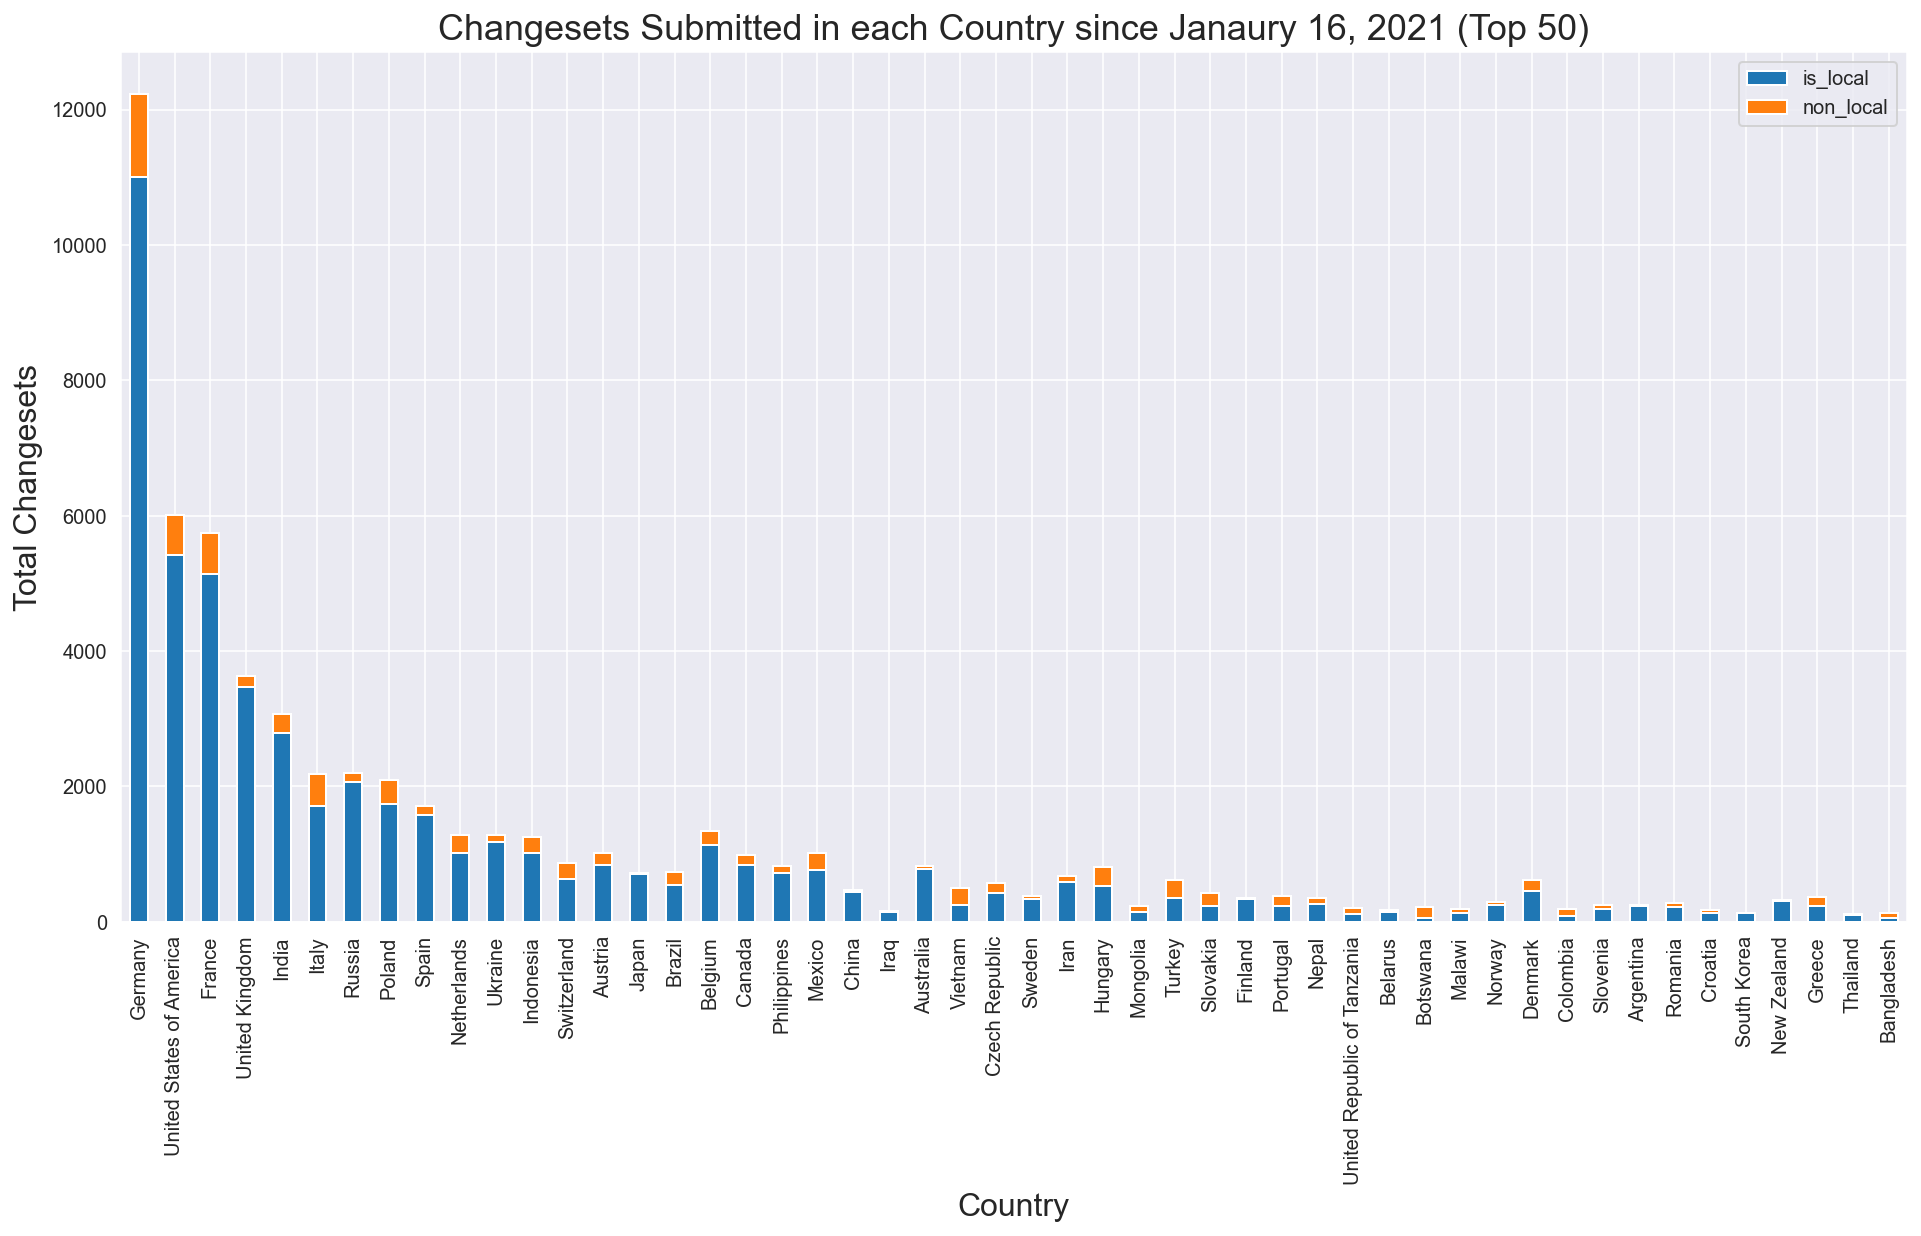

In [19]:
sns.set_style('darkgrid')
gb_country = df.groupby('country').aggregate({'uid':pd.Series.nunique,'user':'count','is_local':sum})
gb_country['non_local'] = gb_country.user - gb_country.is_local
ax = gb_country.sort_values(by='uid', ascending=False).head(50)[['is_local','non_local']].plot.bar(stacked=True, figsize=(16,8))
ax.set_xlabel("Country", fontsize=16); ax.set_ylabel("Total Changesets", fontsize=16);
ax.set_title("Changesets Submitted in each Country since Janaury 16, 2021 (Top 50)", fontsize=18);

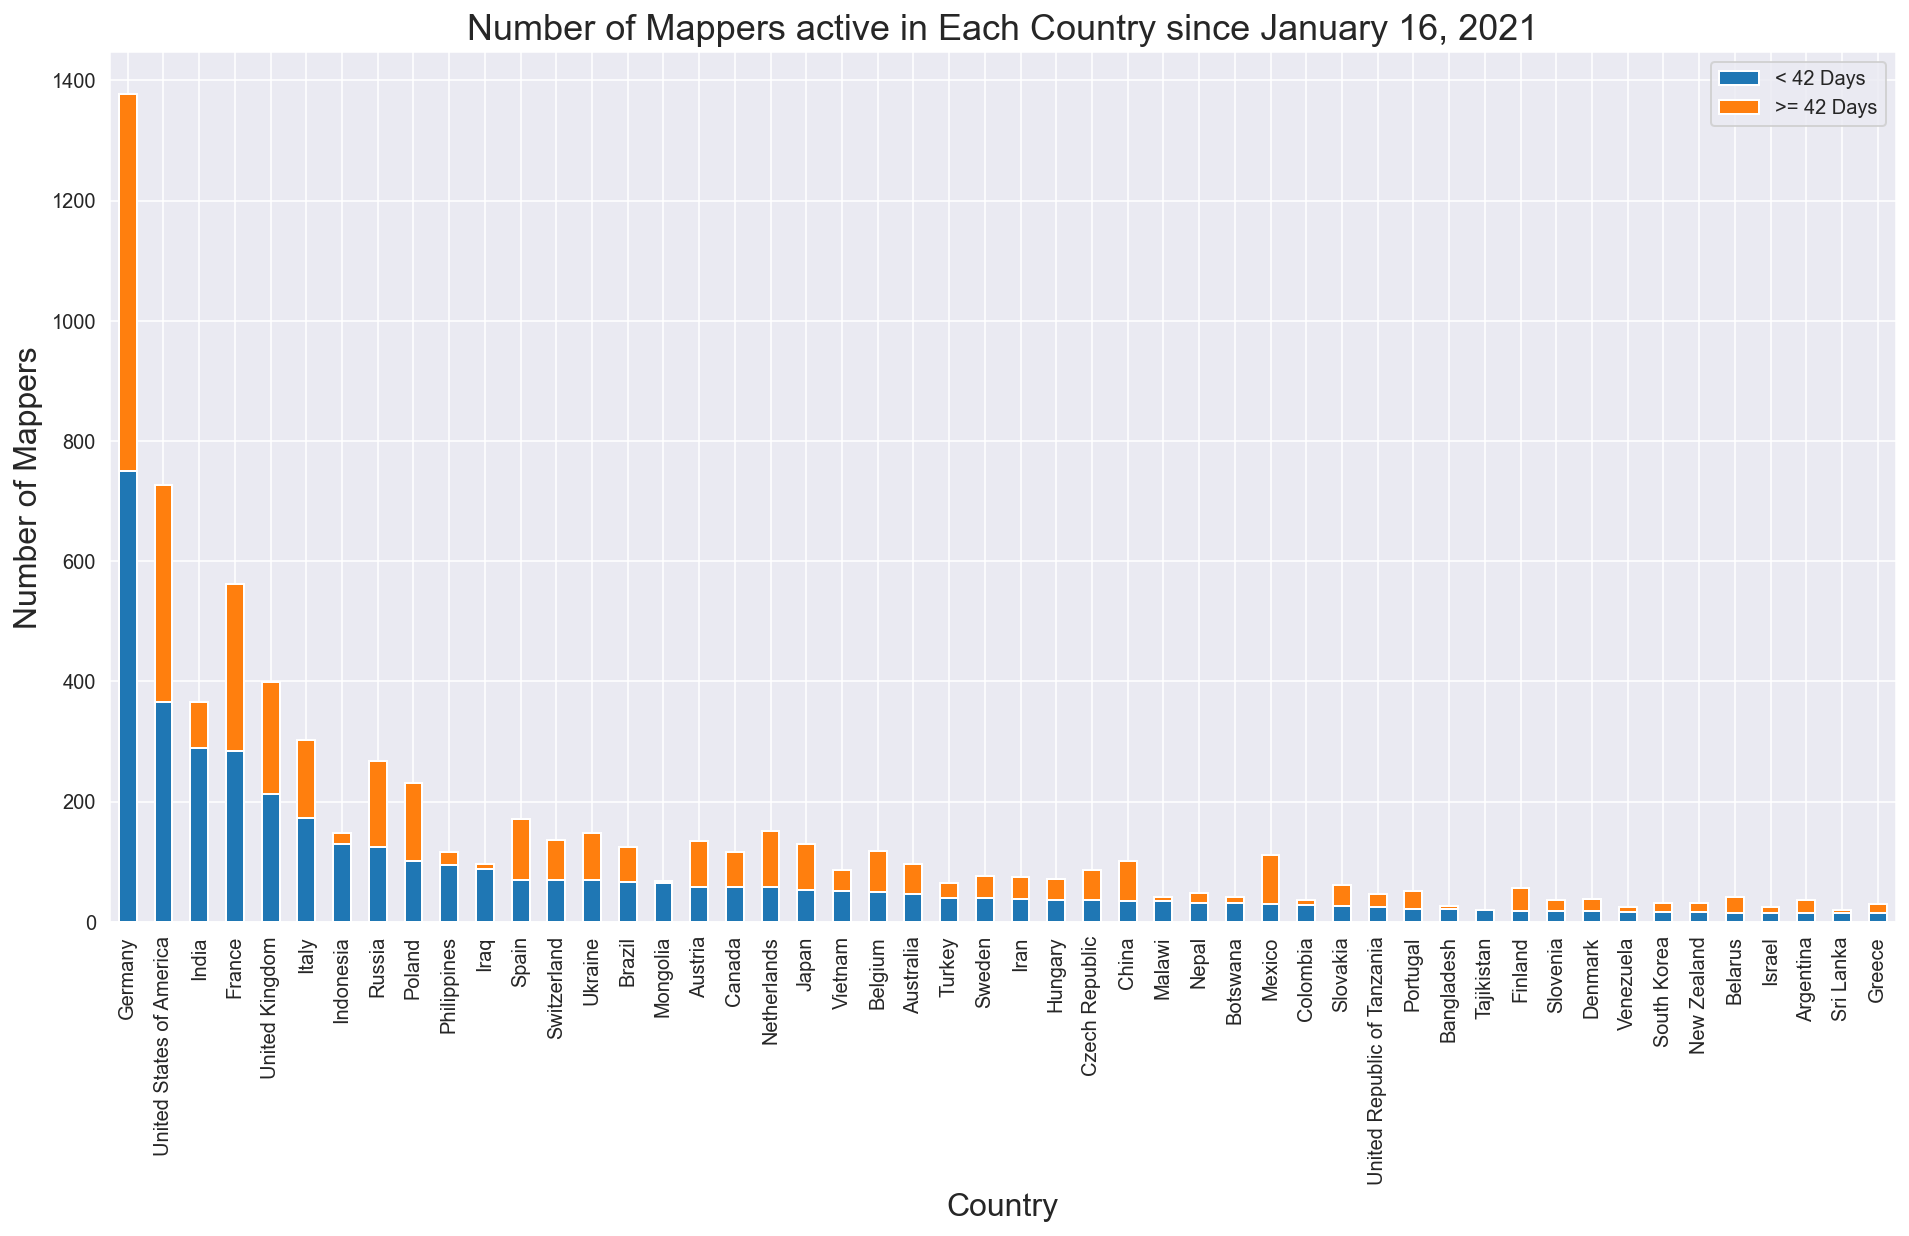

In [25]:
df['is_active_contributor'] = df.editing_days_in_last365 > 41
gb_country_active = df.groupby(['country','is_active_contributor']).aggregate({'uid':pd.Series.nunique}).unstack()

ax = gb_country_active.sort_values(by=('uid',False),ascending=False).head(50).plot.bar(stacked=True, figsize=(16,8));
ax.legend(["< 42 Days",">= 42 Days"])

ax.set_ylabel("Number of Mappers", fontsize=16); ax.set_xlabel("Country", fontsize=16);
ax.set_title("Number of Mappers active in Each Country since January 16, 2021", fontsize=18);